In [1]:
#pip install uproot

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [3]:
# 1️⃣ Get the directory that contains this script
current_dir = Path.cwd()         # e.g. …/project

# 2️⃣ Move up to the parent folder (if you’re already there, this is optional)
parent_dir = current_dir.parent             # e.g. …/ (same as project in this case)
# 3️⃣ Navigate to the sibling folder and file you need
#    Replace 'data' and 'dataset.csv' with your actual folder/file names
target_path = parent_dir / "build" / "hist.root"

# 4️⃣ If you just need the string representation:
target_path_str = str(target_path)

print("Full path:", target_path)

Full path: /home/mazeeqe/Documents/mestrado/code/tomaz-example/build/hist.root


In [4]:
# Constants
z_mass = 91.1880
h_mass = 125.20

# Open the ROOT file
file = uproot.open(target_path_str)
print(file.keys())

# Import events
tree = file["events"]

['events;1', 'NumEventsGenerated;1', 'CrossSection_pb;1', 'TargetLuminosity_fb;1']


In [5]:
# MC weights
weights = tree["weight"].array(library="np")

# Load branches into numpy arrays
invMass = tree["invMass"].array(library="np")
recoilMass = tree["recoilMass"].array(library="np")

def filter_between(arr, low, high):
    """
    Filter the array between two values
    """
    filtered = arr[(arr >= low) & (arr <= high)]

    return filtered

filtered_invMass = filter_between(invMass, 80, 100)
filtered_recoilMass = filter_between(recoilMass, 110, 150)

In [6]:
print("Total expected events =", weights.sum())
# Access parameters
num_events = file["NumEventsGenerated"].value
cross_section = file["CrossSection_pb"].value
target_lumi = file["TargetLuminosity_fb"].value

print("Ngen =", num_events)
print("σ =", cross_section, "pb")
print("L =", target_lumi, "fb^-1")

Total expected events = 0.0016
Ngen = 10000
σ = 1.0 pb
L = 1.0 fb^-1


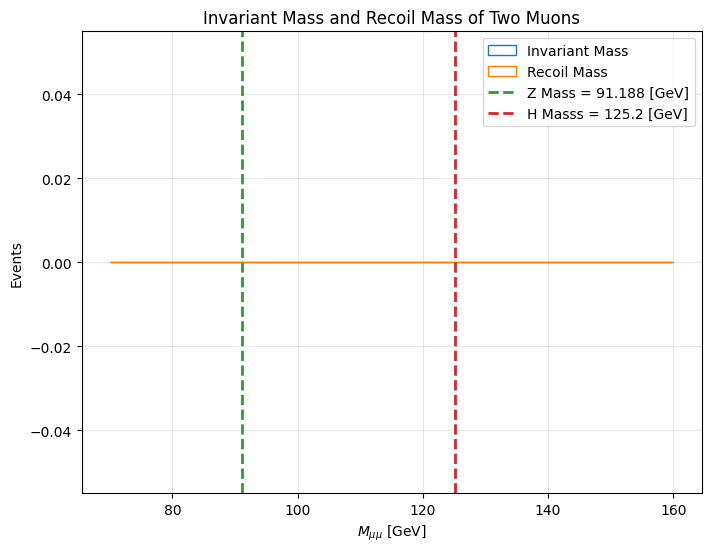

In [7]:
# Plot
plt.figure(figsize=(8,6))

#Invariant mass
plt.hist(filtered_invMass, bins=100, range=(70,160), histtype="step", color="#1f77b4", label="Invariant Mass")
#Recoil mass
plt.hist(filtered_recoilMass, bins=100, range=(70,160), histtype="step", color="#ff7f0e", label="Recoil Mass")
# Vertical line for Z mass
plt.axvline(
    z_mass,
    color='#2ca02c',            # line colour
    linestyle='--',        # dashed line (solid, dashdot, etc.)
    linewidth=2,
    label=f'Z Mass = {z_mass} [GeV]'
)

# Vertical line for Z mass
plt.axvline(
    h_mass,
    color='#d62728',            # line colour
    linestyle='--',        # dashed line (solid, dashdot, etc.)
    linewidth=2,
    label=f'H Masss = {h_mass} [GeV]'
)

plt.xlabel(r"$M_{\mu\mu}$ [GeV]")
plt.ylabel("Events")
plt.title("Invariant Mass and Recoil Mass of Two Muons")
plt.grid(alpha=0.3)

plt.legend()
plt.plot()
plt.savefig("muon_histogram.png")


In [8]:
px = tree["px"].array(library="np")
py = tree["py"].array(library="np")
pz = tree["pz"].array(library="np")

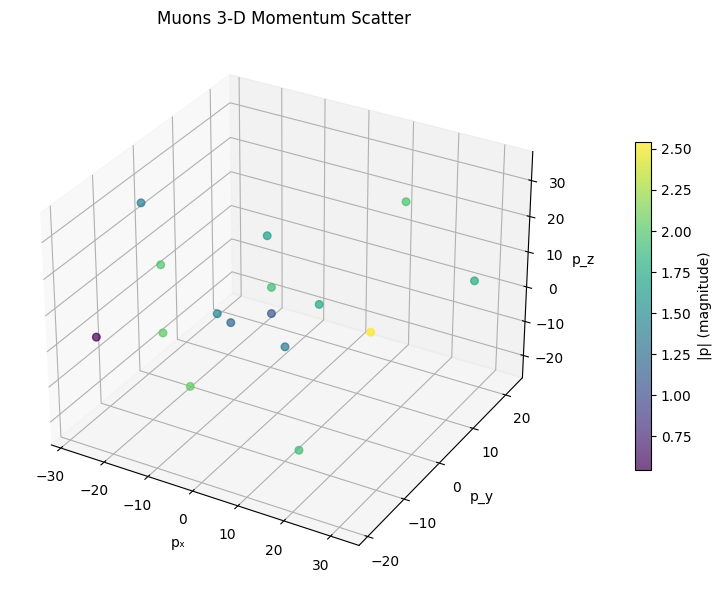

<Figure size 640x480 with 0 Axes>

In [9]:
# Example data – replace with your own array
momenta = np.random.randn(len(px), 3)   # shape (N, 3)

#px, py, pz = momenta.T               # unpack columns

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(px, py, pz,
                c=np.linalg.norm(momenta, axis=1),   # colour by magnitude
                cmap='viridis',
                s=30, alpha=0.7)

ax.set_xlabel('pₓ')
ax.set_ylabel('p_y')
ax.set_zlabel('p_z')
ax.set_title('Muons 3‑D Momentum Scatter')
cbar = fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('|p| (magnitude)')
plt.tight_layout()
plt.show()
plt.savefig("muon_3d_momentum.png")

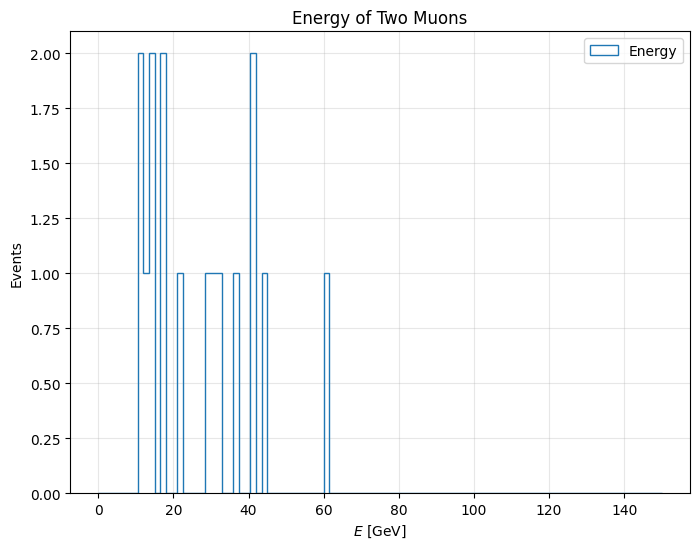

In [10]:
energy = tree["totalEnergy"].array(library="np")

# Plot
plt.figure(figsize=(8,6))

#Invariant mass
plt.hist(energy, bins=100, range=(0,150), histtype="step", color="#1f77b4", label="Energy")

plt.xlabel(r"$E$ [GeV]")
plt.ylabel("Events")
plt.title("Energy of Two Muons")
plt.grid(alpha=0.3)

plt.legend()
plt.plot()
plt.savefig("muon_energy.png")

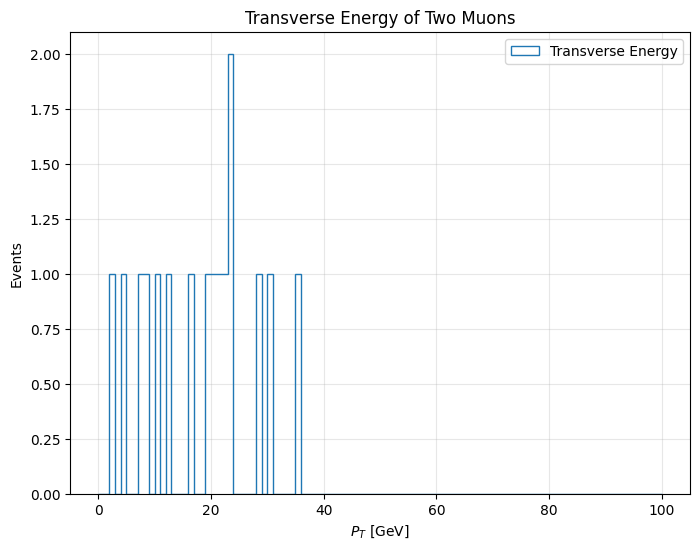

In [11]:
met = tree["met"].array(library="np")

# Plot
plt.figure(figsize=(8,6))

#Invariant mass
plt.hist(met, bins=100, range=(0,100), histtype="step", color="#1f77b4", label="Transverse Energy")

plt.xlabel(r"$P_{T}$ [GeV]")
plt.ylabel("Events")
plt.title("Transverse Energy of Two Muons")
plt.grid(alpha=0.3)

plt.legend()
plt.plot()
plt.savefig("muon_transverse_energy.png")

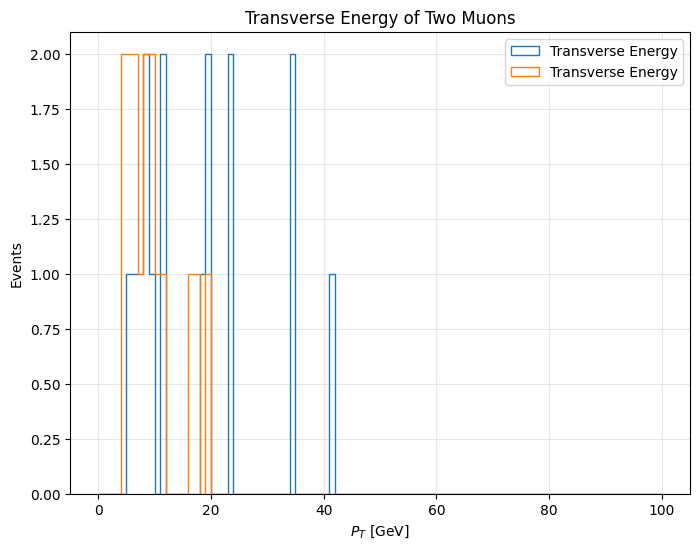

In [12]:
muonEnergy_high = tree["muonEnergy_high"].array(library="np")
muonEnergy_low = tree["muonEnergy_low"].array(library="np")

# Plot
plt.figure(figsize=(8,6))

#Invariant mass
plt.hist(muonEnergy_high, bins=100, range=(0,100), histtype="step", color="#1f77b4", label="Transverse Energy")
plt.hist(muonEnergy_low, bins=100, range=(0,100), histtype="step", color="#ff7f0e", label="Transverse Energy")


plt.xlabel(r"$P_{T}$ [GeV]")
plt.ylabel("Events")
plt.title("Transverse Energy of Two Muons")
plt.grid(alpha=0.3)

plt.legend()
plt.plot()
plt.savefig("muon_transverse_energy.png")

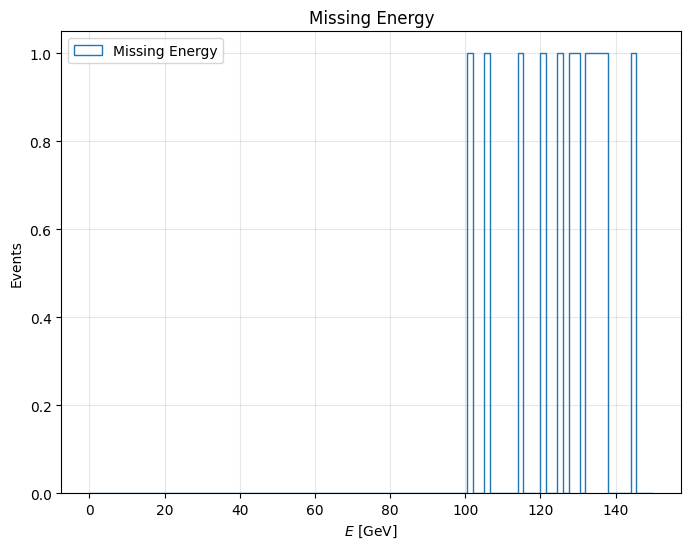

In [13]:
missingEnergy = tree["missingEnergy"].array(library="np")

# Plot
plt.figure(figsize=(8,6))

#Invariant mass
plt.hist(missingEnergy, bins=100, range=(0,150), histtype="step", color="#1f77b4", label="Missing Energy")

plt.xlabel(r"$E$ [GeV]")
plt.ylabel("Events")
plt.title("Missing Energy")
plt.grid(alpha=0.3)

plt.legend()
plt.plot()
plt.savefig("muon_energy.png")

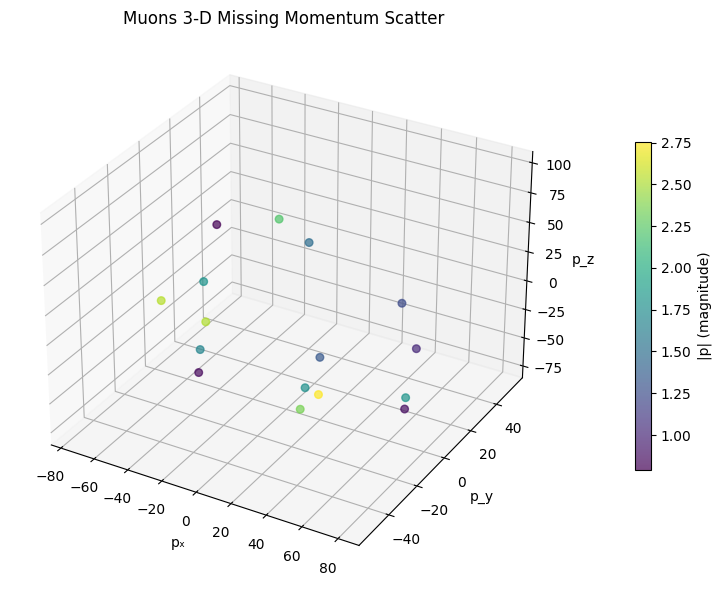

<Figure size 640x480 with 0 Axes>

In [14]:
missingPx = tree["missingPx"].array(library="np")
missingPy = tree["missingPy"].array(library="np")
missingPz = tree["missingPz"].array(library="np")

# Example data – replace with your own array
momenta = np.random.randn(len(missingPx), 3)   # shape (N, 3)

#px, py, pz = momenta.T               # unpack columns

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(missingPx, missingPy, missingPz,
                c=np.linalg.norm(momenta, axis=1),   # colour by magnitude
                cmap='viridis',
                s=30, alpha=0.7)

ax.set_xlabel('pₓ')
ax.set_ylabel('p_y')
ax.set_zlabel('p_z')
ax.set_title('Muons 3‑D Missing Momentum Scatter')
cbar = fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('|p| (magnitude)')
plt.tight_layout()
plt.show()
plt.savefig("muon_3d_momentum.png")